This example quantifies the effect of back-reaction.

# Import Modules

In [1]:
%load_ext autoreload
import sys
sys.path.append("..")
import darkhistory.physics as phys
import numpy as np

In [2]:
%matplotlib inline


Bad key "legend.title_fontsize" on line 41 in
/Users/gridgway/Desktop/DM/DarkHistory/examples/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
%autoreload

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

from astropy.io import fits

import numpy as np
import copy
import pickle
import darkhistory.spec.spectools as spectools
from tqdm import tqdm_notebook as tqdm
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d

import main

# %autoreload

# import matplotlib
# matplotlib.rc_file('matplotlibrc')
# import matplotlib.pyplot as plt

# %matplotlib inline

# matplotlib.rcParams['figure.figsize'] = [10,10]


# from astropy.io import fits

# import numpy as np
# import copy
# import pickle

# import darkhistory.physics as phys
# import darkhistory.utilities as utils
# import darkhistory.spec.spectools as spectools
# import darkhistory.spec.transferfunction as tf
# import darkhistory.spec.transferfunclist as tflist
# from darkhistory.spec.spectrum import Spectrum
# from darkhistory.spec.spectra import Spectra
# import darkhistory.history.tla as tla

# from scipy.interpolate import interp1d
# from scipy.interpolate import interp2d

# from tqdm import tqdm_notebook as tqdm

# from darkhistory.electrons.ics.ics_spectrum import ics_spec
# from darkhistory.electrons.ics.ics_engloss_spectrum import engloss_spec
# from darkhistory.electrons.ics.ics_cooling import get_ics_cooling_tf

# from darkhistory.low_energy.lowE_deposition import compute_fs
# import main

# from tqdm import tqdm_notebook as tqdm

# np.set_printoptions(threshold=np.nan)


Bad key "legend.title_fontsize" on line 41 in
matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [4]:
#Annihilation or decay?
inj_type = 'decay'

#Annihilate/Decay into
inj_particle = 'photon'

#Useful definitions
if inj_particle == 'electron':
    inj_str = 'elec'
    mass = phys.me
else:
    inj_str = 'phot'
    mass = 0

# Load Max $\langle \sigma v \rangle$ and $\tau$

In [9]:
user = 'gridgway'
f_elec_CMB_raw = np.loadtxt('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/TLA_code/fFromIonBaseline3keV_electron_extended.dat', delimiter=',')
log10eng_elec_CMB  = f_elec_CMB_raw[0:2760:69, 0]
log10rs_elec_CMB = f_elec_CMB_raw[0:69, 1] 

f_phot_CMB_raw = np.loadtxt('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/TLA_code/fFromIonBaseline3keV_photon.dat', delimiter=',')
log10eng_phot_CMB  = f_phot_CMB_raw[0:2800:70, 0]
log10rs_phot_CMB = f_phot_CMB_raw[0:70, 1] 

f_elec_CMB_raw = np.transpose(np.reshape(f_elec_CMB_raw[:,2], (40,69)))
f_phot_CMB_raw = np.transpose(np.reshape(f_phot_CMB_raw[:,2], (40,70)))

f_elec_CMB = interp2d(log10eng_elec_CMB, log10rs_elec_CMB, f_elec_CMB_raw)
f_phot_CMB = interp2d(log10eng_phot_CMB, log10rs_phot_CMB, f_phot_CMB_raw)

decay_elec_CMB_raw = np.loadtxt('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/TLA_code/CMB_limits_elec_decay.csv', delimiter=',')
decay_phot_CMB_raw = np.loadtxt('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/TLA_code/CMB_limits_phot_decay.csv', delimiter=',')

decay_elec_CMB = interp1d(np.transpose(decay_elec_CMB_raw)[0,:], np.transpose(decay_elec_CMB_raw)[1,:])
decay_phot_CMB = interp1d(np.transpose(decay_phot_CMB_raw)[0,:], np.transpose(decay_phot_CMB_raw)[1,:])

def max_xsec_elec_CMB(mDM, injection_type):
    if injection_type == 'swave':
        return 4.1e-28*(mDM*1e-9)/f_elec_CMB(np.log10(mDM-phys.me), np.log10(601))
    elif injection_type == 'decay':
        return decay_elec_CMB(mDM*1e-9)

def max_xsec_phot_CMB(mDM, injection_type):
    if injection_type == 'swave':
        return 4.1e-28*(mDM*1e-9)/f_phot_CMB(np.log10(mDM), np.log10(601))
    elif injection_type == 'decay':
        return decay_phot_CMB(mDM*1e-9)

# Calculate With and Without back-reaction

In [11]:
log10eng0 = 3.6989700794219966
log10eng = np.array([log10eng0 + 0.23252559*i for i in np.arange(40)])
log10eng[-1] = 12.60150599

In [12]:
%autoreload

def get_column(i, data, diff_list, inj_particle, inj_type, end_rs=4.995):
    """ inj_type = 'swave' has not been worked out yet
    """
    #injection energy, DM mass, center-of-mass energy
    Einj = 10**log10eng[i]
    mDM = 2*Einj + 2*mass
    Ecom=mDM
    
    
    if inj_particle == 'photon':
        print('photon xsec')
        primary = 'phot_delta'
        sigmav = max_xsec_phot_CMB(mDM, 'swave')
        tau = max_xsec_phot_CMB(mDM, 'decay')
        coarsen_factor=2
    else:
        print('electron xsec')
        primary = 'elec_delta'
        sigmav = max_xsec_elec_CMB(mDM, 'swave')
        tau = max_xsec_elec_CMB(mDM, 'decay')
        coarsen_factor=8
        
    if inj_type == 'decay':
        def struct_boost(rs):
            return 1
    else:
        struct_boost = phys.struct_boost_func('einasto_with_subs')
        mDM = mDM/2
        Ecom = 2*mDM
    
    def rate_func_N(rs):
        return phys.inj_rate(inj_type, rs, mDM=mDM, sigmav=sigmav, tau=tau)*struct_boost(rs)/Ecom
    def rate_func_eng(rs):
        return phys.inj_rate(inj_type, rs, mDM=mDM, sigmav=sigmav, tau=tau)*struct_boost(rs)
        
    a = main.evolve(
        primary=primary,
        rate_func_N=rate_func_N, rate_func_eng=rate_func_eng,
        DM_process=inj_type, mDM=mDM, sigmav=sigmav, lifetime=tau,
        start_rs = 3000, end_rs=end_rs,
        coarsen_factor=coarsen_factor, backreaction=False,
        struct_boost=struct_boost
    )
    
    b = main.evolve(
        primary=primary,
        rate_func_N=rate_func_N, rate_func_eng=rate_func_eng,
        DM_process=inj_type, mDM=mDM, sigmav=sigmav, lifetime=tau,
        start_rs = 3000, end_rs=end_rs,
        coarsen_factor=coarsen_factor, backreaction=True,
        struct_boost=struct_boost
    )
    
    data[i] = (a,b)

    diff_list[i] = (1-b['Tm']/a['Tm']) * 100

In [ ]:
%autoreload
diff_list = [None for i in np.arange(len(log10eng))]
data = [None for i in np.arange(len(log10eng))]

for k in tqdm(np.arange(40)):
    get_column(k, data, diff_list, inj_particle, inj_type, end_rs=4.995)

# pickle.dump(diff_list, open('/Users/gridgway/Desktop/backReact_'+inj_str+'_residuals.p', "wb"))
# pickle.dump(diff_list, open('/Users/'+user+'/Dropbox (MIT)/Photon Deposition/backReact_phot_residuals_2019_01_23.p', "wb"))

photon xsec
****** Loading transfer functions... ******
    for propagating photons...   Done!
    for low-energy photons...  

In [306]:
inj_particle = 'electron'
log10eng0 = 3.6989700794219966
log10eng = np.array([log10eng0 + 0.23252559*i for i in np.arange(40)])
log10eng[-1] = np.log10(highengphot_tf_interp.eng[-1])*.99
log10eng = log10eng[6:]

In [307]:
%autoreload
diff_list_elec = [None for i in np.arange(len(log10eng))]
data_elec = [None for i in np.arange(len(log10eng))]

for k in tqdm(np.arange(len(log10eng))):
    get_column(k, data_elec, diff_list_elec, inj_particle, inj_type, end_rs=4.995)

# pickle.dump(diff_list, open('/Users/gridgway/Desktop/backReact_'+inj_str+'_residuals.p', "wb"))
pickle.dump(diff_list_elec, open('/Users/'+user+'/Dropbox (MIT)/Photon Deposition/backReact_elec_residuals_2019_01_23.p', "wb"))

electron xsec


../darkhistory/spec/spectra.py:401: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  np.issubdtype(type(other), float)
../darkhistory/spec/spectra.py:402: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  or np.issubdtype(type(other), int)
../darkhistory/history/tla.py:212: RuntimeWarning: overflow encountered in cosh
  return 2 * np.cosh(yHII)**2 * -phys.dtdz(rs) * (
../darkhistory/history/tla.py:185: RuntimeWarning: overflow encountered in cosh
  + dyHeIII_dz(yHII, yHeII, yHeIII, T_m, rs)
../darkhistory/history/tla.py:185: RuntimeWarning: invalid value encountered in double_scalars
  + dyHeIII_dz(yHII, yHeII, yHeIII, T_m, rs)
/Users/gridgway/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: R

electron xsec


electron xsec


electron xsec


electron xsec


electron xsec


electron xsec


electron xsec


electron xsec


electron xsec


electron xsec


electron xsec


electron xsec


electron xsec


electron xsec


electron xsec


electron xsec


electron xsec


electron xsec


electron xsec


electron xsec


electron xsec


electron xsec


electron xsec


electron xsec


electron xsec


electron xsec


electron xsec


electron xsec


electron xsec


electron xsec


electron xsec


electron xsec


electron xsec


In [451]:
user = 'gridgway'
def save_as_pickled_object(obj, filepath):
    """
    This is a defensive way to write pickle.write, allowing for very large files on all platforms
    """
    max_bytes = 2**31 - 1
    bytes_out = pickle.dumps(obj)
    n_bytes = sys.getsizeof(bytes_out)
    with open(filepath, 'wb') as f_out:
        for idx in range(0, n_bytes, max_bytes):
            f_out.write(bytes_out[idx:idx+max_bytes])

save_as_pickled_object(data, '/Users/'+user+'/Desktop/Example14_data_phot.p')

In [452]:
save_as_pickled_object(data_elec, '/Users/'+user+'/Desktop/Example14_data_elec.p')

In [285]:
tmp = [None for i in np.arange(38)]
for i in np.arange(38):
#     tmp[i] = (data[i][1][1] - data[i][0][1])/phys.kB
    tmp[i] = diff_list[i].copy()
tmp = np.array(tmp)

In [ ]:
tmp = main.evolve(
        elec_spec_init, phot_spec_init,
        rate_func_N, rate_func_eng, end_rs,
        highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
        highengdep_interp, CMB_engloss_interp,
        ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf,
        coarsen_factor=1, std_soln=True,
        reion_switch=False,
        struct_boost=None,
        ics_only=False, separate_higheng=True, CMB_subtracted=CMB_subtracted,
        xH_func=xe_idl_func, xHe_func=xHe_idl_func, user=None, verbose=False, 
        use_tqdm=True
    )

## Comparisons to 1604.xxxxx Fig 15.

Plot of ionization vs. rs

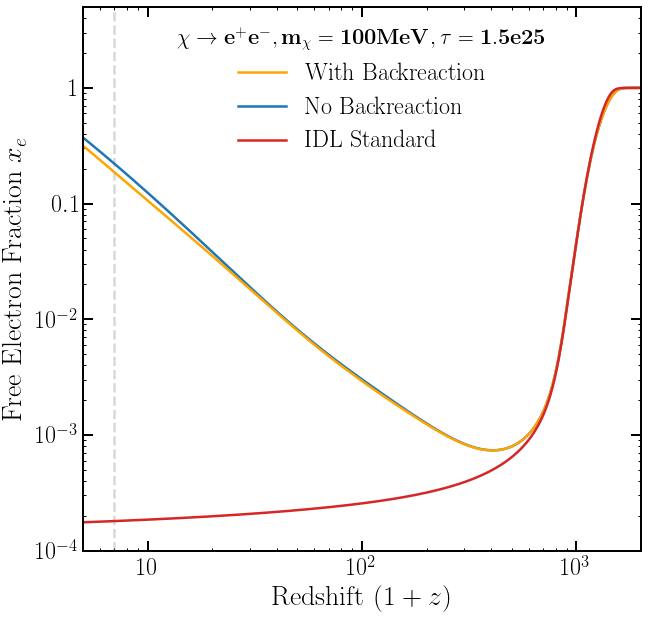

In [443]:
plt.figure()
ax = plt.gca()
ax.loglog()

plt.xlabel('Redshift $(1+z)$')
plt.ylabel('Free Electron Fraction $x_e$')

plt.axis([5, 2e3, 1e-4, 5])
plt.axvline(7, color='gray', linestyle='--', alpha=0.3)

# plt.plot(idl_redshift, data[-1][0][0][:,0], label='DH')
plot_noBR, = plt.plot(idl_redshift, a[0][:,0], label='No Backreaction', color='C0')
plot_BR, = plt.plot(idl_redshift, b[0][:,0], label='With Backreaction', color='orange')
plot_std, = plt.plot(idl_redshift, xe_idl, label='IDL Standard', color='C3')

legend = plt.legend(handles=[plot_BR, plot_noBR, plot_std], loc=0, 
#            borderaxespad=0, 
           frameon=False, title='$\mathbf{\chi \\rightarrow e^+e^-, m_\chi = 100MeV, \\tau=1.5e25}$')
legend.get_title().set_fontsize('22')

plt.savefig('/Users/'+user+'/Desktop/Example14_1604_comparison_xe.png')

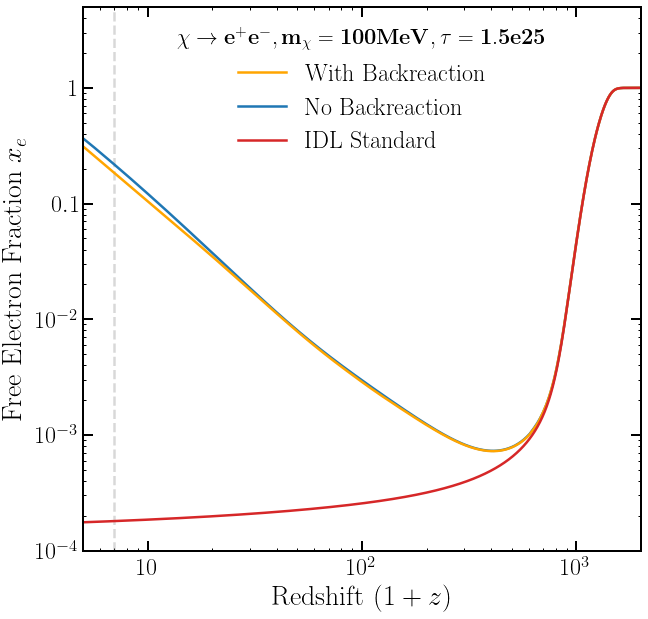

In [58]:
plt.figure()
ax = plt.gca()
ax.loglog()

plt.xlabel('Redshift $(1+z)$')
plt.ylabel('Free Electron Fraction $x_e$')

plt.axis([5, 2e3, 1e-4, 5])
plt.axvline(7, color='gray', linestyle='--', alpha=0.3)

# plt.plot(idl_redshift, data[-1][0][0][:,0], label='DH')
plot_noBR, = plt.plot(idl_redshift[::coarsen_factor], a[0][:,0], label='No Backreaction', color='C0')
plot_BR, = plt.plot(idl_redshift[::coarsen_factor], b[0][:,0], label='With Backreaction', color='orange')
plot_std, = plt.plot(idl_redshift, xe_idl, label='IDL Standard', color='C3')

legend = plt.legend(handles=[plot_BR, plot_noBR, plot_std], loc=0, 
#            borderaxespad=0, 
           frameon=False, title='$\mathbf{\chi \\rightarrow e^+e^-, m_\chi = 100MeV, \\tau=1.5e25}$')
legend.get_title().set_fontsize('22')

# plt.savefig('/Users/'+user+'/Desktop/Example14_1604_comparison_xe.png')

Plot of T vs. rs

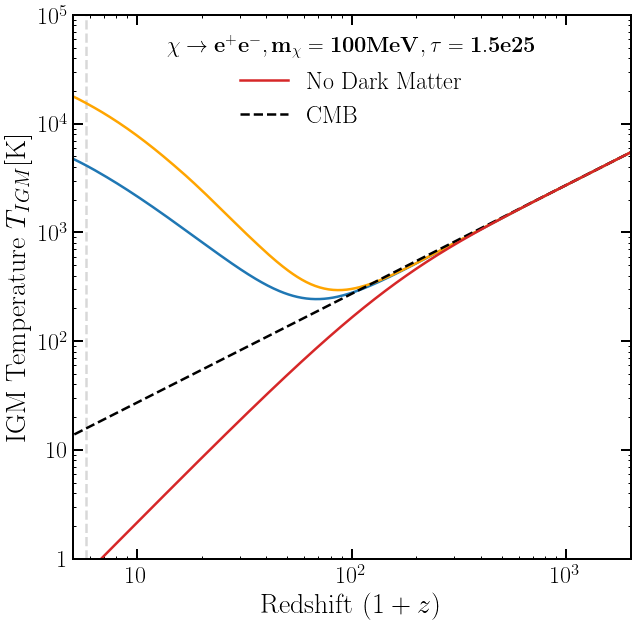

In [56]:
plt.figure()
ax = plt.gca()
ax.loglog()

plt.xlabel('Redshift $(1+z)$')
plt.ylabel('IGM Temperature $T_{IGM}$[K]')

plt.axis([5, 2e3, 1, 1e5])
plt.axvline(5.8, color='gray', linestyle='--', alpha=0.3)

# plt.plot(idl_redshift, data[-1][0][0][:,0], label='DH')
plot_noBR, = plt.plot(idl_redshift[::coarsen_factor], a[1][:]/phys.kB, label='No Backreaction', color='C0')
plot_BR, = plt.plot(idl_redshift[::coarsen_factor], b[1][:]/phys.kB, label='With Backreaction', color='orange')
plot_CMB, = plt.plot(idl_redshift, phys.TCMB(idl_redshift)/phys.kB, label='CMB', color='k', linestyle='--')
plot_std, = plt.plot(idl_redshift, tmp[1][:]/phys.kB, label='No Dark Matter', color='C3')

# legend = plt.legend(handles=[plot_noBR, plot_BR, plot_std, plot_CMB], loc=9,
legend = plt.legend(handles=[plot_std, plot_CMB], loc=9,
#            borderaxespad=0, 
           frameon=False, title='$\mathbf{\chi \\rightarrow e^+e^-, m_\chi = 100MeV, \\tau=1.5e25}$')
legend.get_title().set_fontsize('22')

# plt.savefig('/Users/'+user+'/Desktop/Example14_1604_comparison_T.png')

Generating standard $T_{IGM}$ history

In [32]:
def rate_func_N(rs):
    return 1e-100
def rate_func_eng(rs):
    return 1e-100

elec_spec_init = Spectrum(eleceng,
                         np.zeros_like(eleceng),
                         spec_type='N',
                         rs=3000)

phot_spec_init = Spectrum(photeng,
                         np.zeros_like(photeng),
                         spec_type='N',
                         rs=3000)

end_rs = 4.995

tmp = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_N, rate_func_eng, end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
    highengdep_interp, CMB_engloss_interp,
#     ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf,
    coarsen_factor=1, std_soln=True,
    reion_switch=False,
    struct_boost=None,
    ics_only=False, separate_higheng=True, CMB_subtracted=CMB_subtracted,
    xH_func=xe_idl_func, xHe_func=xHe_idl_func, user=None, verbose=False, 
    use_tqdm=True
)

../darkhistory/physics.py:303: RuntimeWarning: invalid value encountered in double_scalars
  / (1 + 0.6703 * (conv_fac*T_m)**0.5300)


Generating Dark Matter ionization and Temperature histories

In [59]:
%autoreload
#injection energy, DM mass, center-of-mass energy
mDM = 1e8
Einj = (mDM-phys.me)/2
coarsen_factor=16

Ecom=mDM

tau = 1.5e25

def rate_func_N(rs):
    return phys.inj_rate(inj_type, rs, mDM=mDM, tau=tau)/Ecom
def rate_func_eng(rs):
    return phys.inj_rate(inj_type, rs, mDM=mDM, tau=tau)

Etmp = eleceng[eleceng < Einj][-1]
elec_spec_init = spectools.rebin_N_arr(
    np.array([2*Einj/Etmp]),
    np.array([Etmp]),
    eleceng
)
elec_spec_init.rs = 3000
elec_spec_init.switch_spec_type()

phot_spec_init = Spectrum(photeng,
                         np.zeros_like(photeng),
                         spec_type='N',
                         rs=3000)

a = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_N, rate_func_eng, end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
    highengdep_interp, CMB_engloss_interp,
    ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf,
    coarsen_factor=coarsen_factor, std_soln=True,
    reion_switch=False,
    struct_boost=None,
    ics_only=False, separate_higheng=True, CMB_subtracted=CMB_subtracted,
    xH_func=xe_idl_func, xHe_func=xHe_idl_func, user=None, verbose=False, 
    use_tqdm=True
)

b = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_N, rate_func_eng, end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
    highengdep_interp, CMB_engloss_interp,
    ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf,
    coarsen_factor=coarsen_factor, std_soln=False,
    reion_switch=False,
    struct_boost=None,
    ics_only=False, separate_higheng=True, CMB_subtracted=CMB_subtracted,
    xH_func=xe_idl_func, xHe_func=xHe_idl_func, user=None, verbose=False, 
    use_tqdm=True
)

../darkhistory/spec/spectra.py:401: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  np.issubdtype(type(other), float)
../darkhistory/spec/spectra.py:402: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  or np.issubdtype(type(other), int)


KeyboardInterrupt: 

## Heat Plots of the Effects of Backreaction

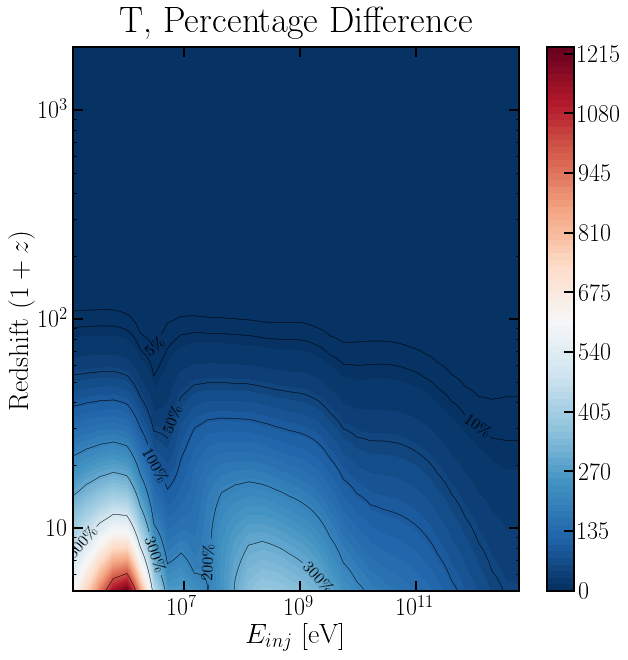

In [315]:
user = 'gridgway'

rs_list = np.exp(np.arange(np.log(3000), np.log(4.996), step=-0.001))

fz_phot_decay = np.loadtxt('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/TLA_code/fz_photon_decay.dat', delimiter=',')
log10eng = fz_phot_decay[0:2800:70, 0]
log10eng = log10eng[6:]


plt.figure()

ax = plt.gca()
ax.loglog()

# plt_heating = plt.contour(
#     10**log10eng, rs_list, 
#     np.transpose(np.abs(diff_list)),
# #     np.transpose(np.abs(tmp)),
#     levels=[15, 30, 45, 60, 75, 90, 105],
#     linewidths=0.5,
#     colors='k'
# )

plt_heating = plt.contour(
    10**log10eng, rs_list, 
    np.transpose(np.abs(diff_list_elec)),
    levels=[5, 10, 50, 100, 200, 300, 500, 1000],
    linewidths=0.5,
    colors='k'
)

plt.axis([10**log10eng[0], 10**log10eng[-1], 5, 2e3])

# labels = { 
#     15:r'$15$\%', 
#     30:r'$30$\%',
#     45:r'$45$\%',
#     60:r'$60$\%',
#     75:r'$75$\%',
#     90:r'$90$\%',
#     105:r'$105$\%'
# }

labels = { 
    5:r'$5$\%', 
    10:r'$10$\%', 
    50:r'$50$\%',
    100:r'$100$\%',
    200:r'$200$\%',
    300:r'$300$\%',
    500:r'$500$\%',
    1000:r'$1000$\%'
}

plt.clabel(
    plt_heating, inline=True, fontsize=16, rightside_up=True,
    fmt=labels
)

cntr1 = ax.contourf(10**log10eng, rs_list, np.transpose(np.abs(diff_list_elec)), 100, cmap="RdBu_r")
# cntr1 = ax.contourf(10**log10eng, rs_list, np.transpose(np.abs(tmp)), 100, cmap="RdBu_r")

plt.colorbar(cntr1, ax=ax)

# plt.title(r'\bf{$\delta_{T_m}$}')
plt.title('T, Percentage Difference')
plt.ylabel(r'Redshift ($1+z$)')
plt.xlabel(r'$E_{inj}$ [eV]')

user='gridgway'
# plt.savefig('/Users/'+user+'/Dropbox (MIT)/Photon Deposition/plots/backReact_phot_residuals.pdf')
# plt.savefig('/Users/'+user+'/Desktop/backReact_phot_residuals.png')

plt.savefig('/Users/'+user+'/Desktop/backReact_elec_residuals.png')
# plt.savefig('/Users/'+user+'/Desktop/backReact_absolute_diff.png')